Link for first 3 parts pdf- https://drive.google.com/file/d/1VyXRpfJ6MNcvsYvp7R0bqvBgsm_YVBbr/view?usp=sharing

Also attached on Brightspace if unable to access

In [ ]:
import numpy as np
import numpy as asarray
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist


(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Bacprop of Maxpooling and Convolution

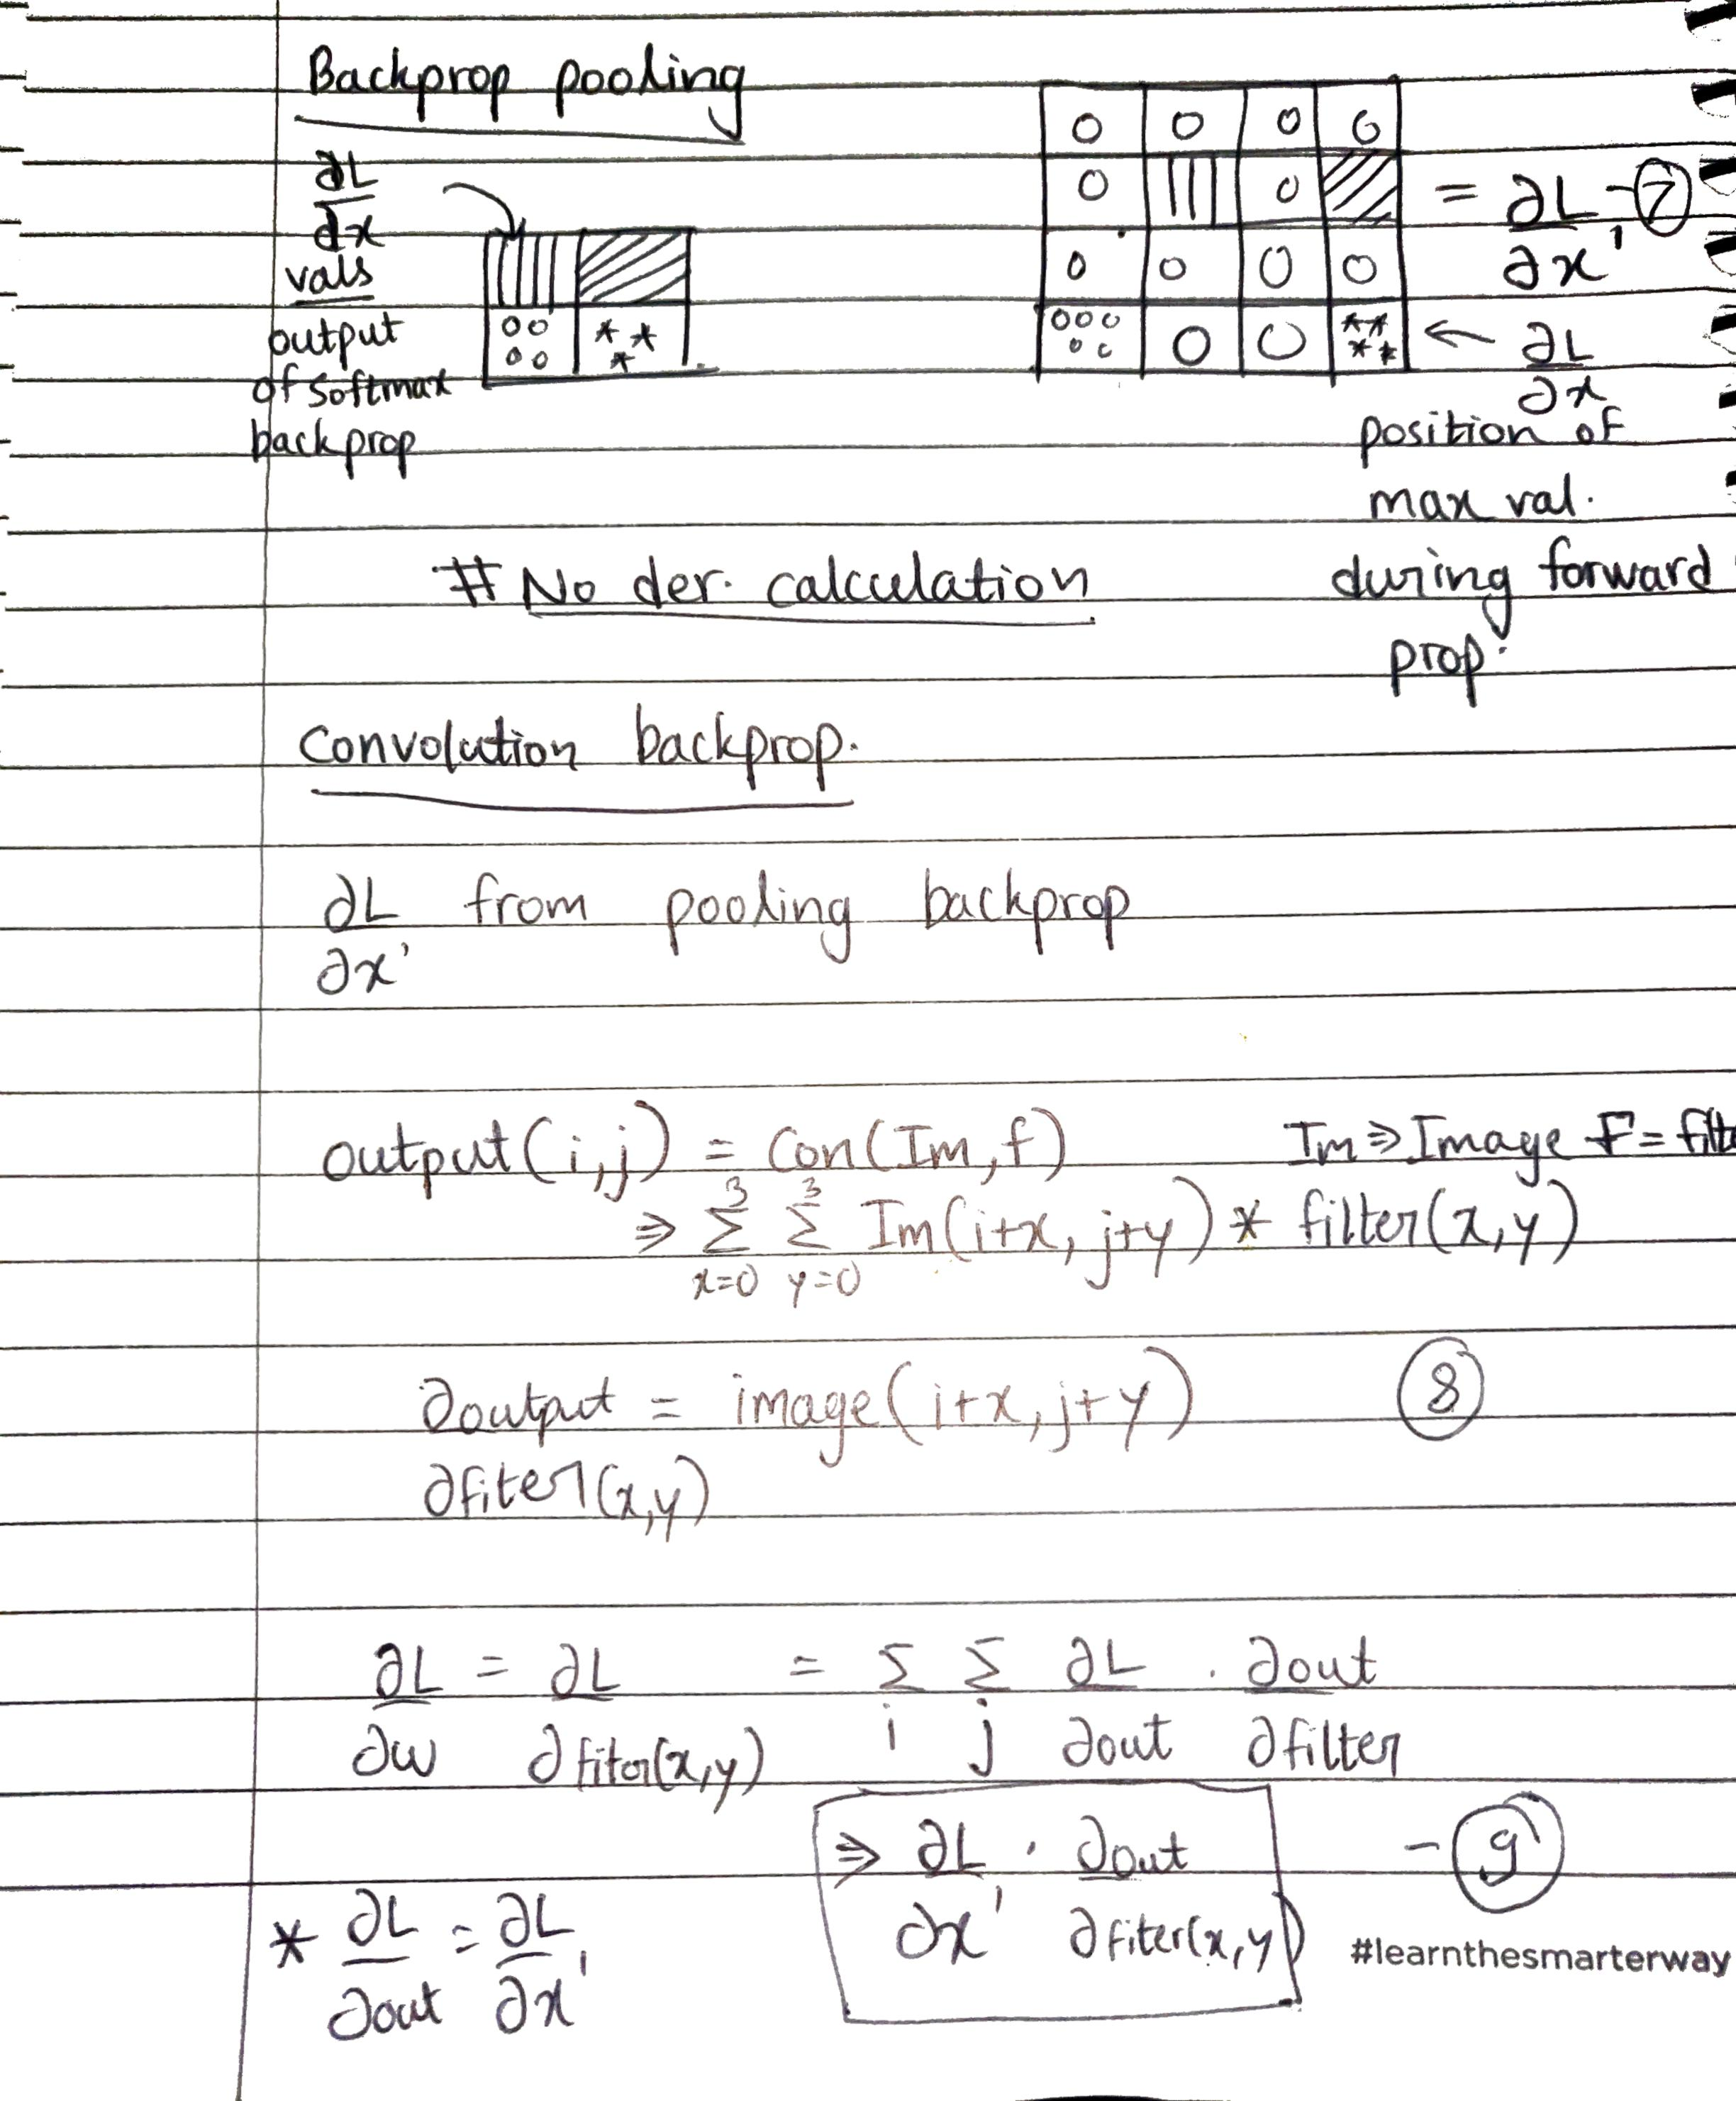

In [ ]:
class Conv_op:
  def __init__(self,num_filters, filter_size):
    self.num_filters=num_filters
    self.filter_size=filter_size
    self.conv_filter=np.random.randn(num_filters,filter_size,filter_size)/(filter_size * filter_size)
  
  def image_region(self, image):
    height, width = image.shape
    self.image = image
    for j in range(height - self.filter_size+1):
      for k in range(width- self.filter_size + 1):
        image_patch=image[j:(j+self.filter_size), k:(k+self.filter_size)]  
        yield image_patch, j, k #striding action please refer Part c for dimensions as the image is fed into the convolution layers. We get image patches after convolutions
  def forward_prop(self, image):
    height, width = image.shape
    conv_out= np.zeros((height - self.filter_size+1,width-self.filter_size + 1, self.num_filters))
    for image_patch, i , j in self.image_region(image):
      conv_out[i,j]= np.sum(image_patch*self.conv_filter, axis=(1,2))
    return conv_out
  def back_prop(self, dL_dout, learning_rate):
    dL_dF_params = np.zeros(self.conv_filter.shape) #initialising it to 0 first
    for image_patch, i , j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k]+=image_patch*dL_dout[i,j,k] #refer Eqn 9 here image patches are the convolved image blocks as the the filter takes the stride
    self.conv_filter-=learning_rate*dL_dF_params
    return dL_dF_params

In [ ]:
class Max_Pool:
  def __init__(self,filter_size):
    self.filter_size=filter_size
  def image_region(self,image):
    new_height=image.shape[0]//self.filter_size
    new_width=image.shape[1]//self.filter_size
    self.image=image

    for i in range(new_height):
      for j in range(new_width):
        image_patch= image[(i*self.filter_size): (i*self.filter_size + self.filter_size), (j*self.filter_size):(j*self.filter_size + self.filter_size)]
        yield image_patch, i, j #Similar to convolution where we store image patches after convolving our image with a filter.
  def forward_prop(self, image):
    height,width, num_filters=image.shape
    output=np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    for image_patch, i , j in self.image_region(image):
      output[i,j]=np.amax(image_patch, axis=(0,1))

    return output

  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters=image_patch.shape
      maximum_val = np.amax(image_patch, axis=(0,1))
      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1, j1, k1]== maximum_val[k1]: 
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1,k1]=dL_dout[i,j,k1] #check Eqn 7 in the above image.Only gives output if value is max.
      return dL_dmax_pool

Initial Equations

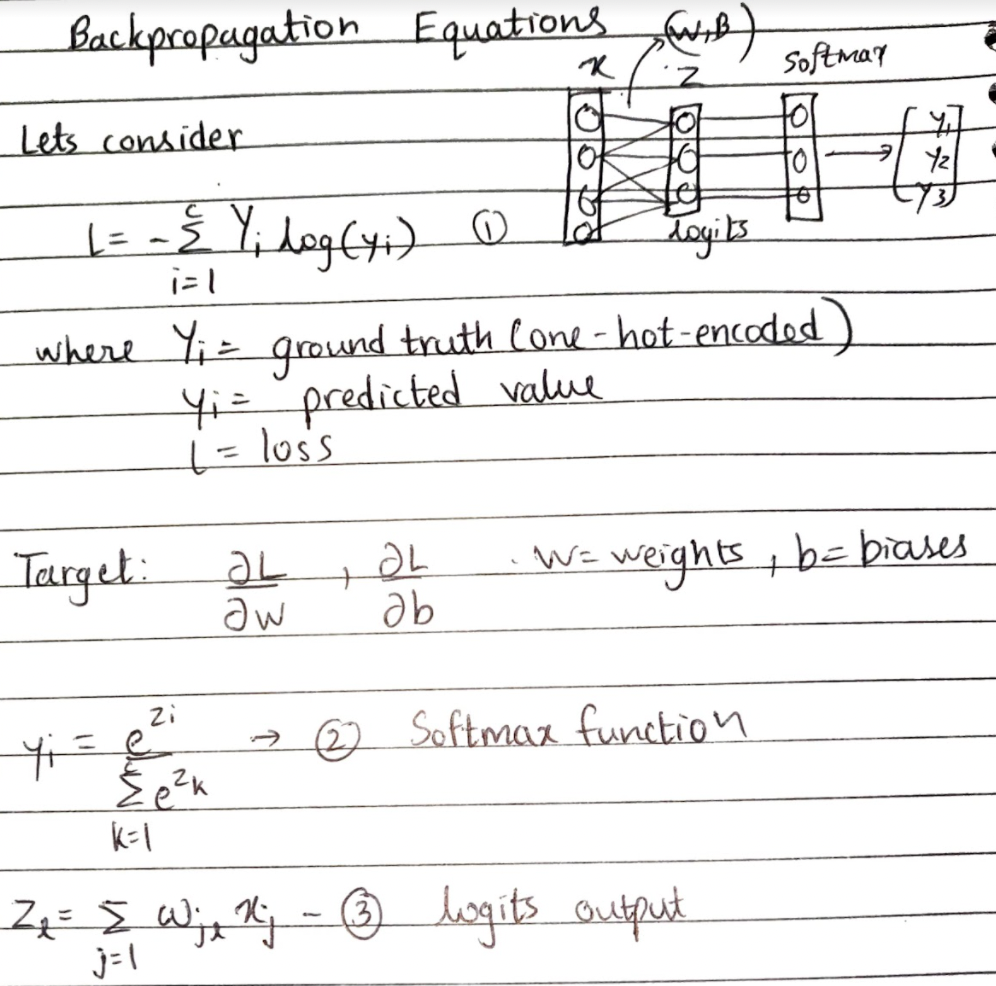

Target dl/dw

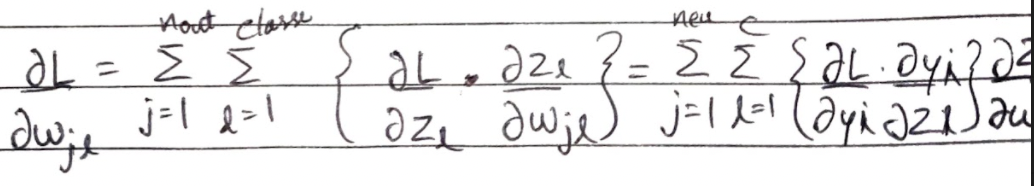

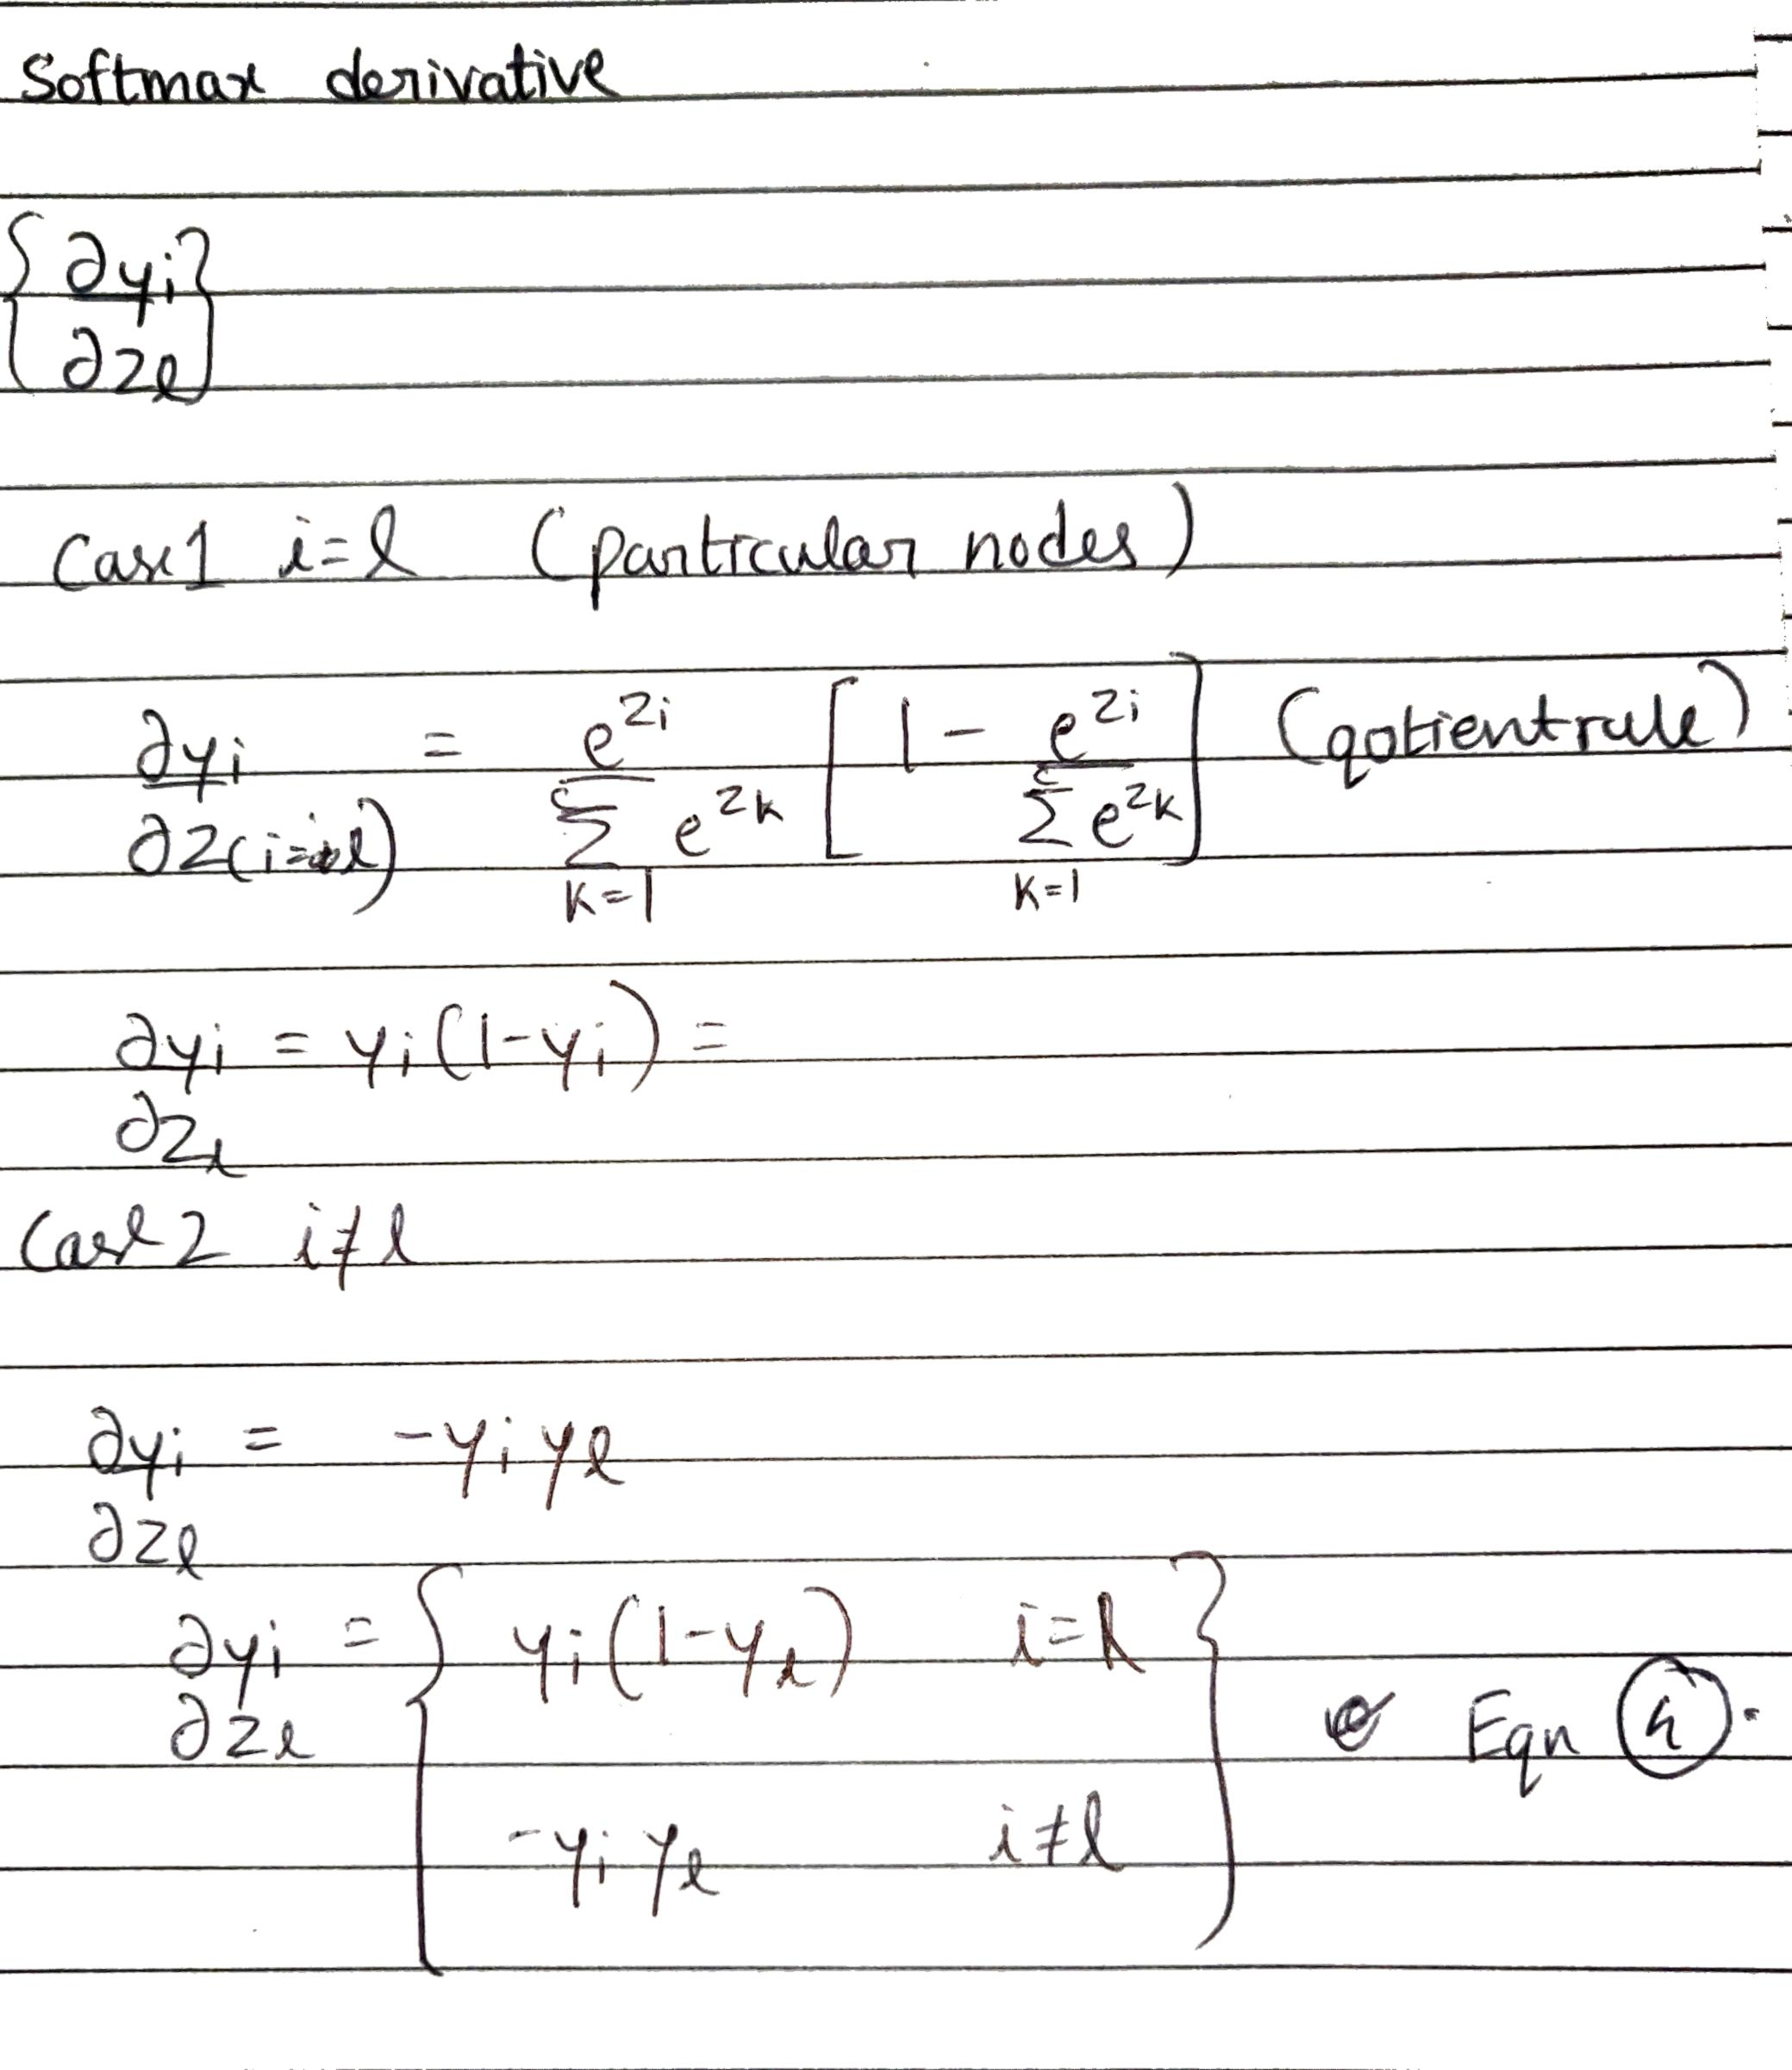

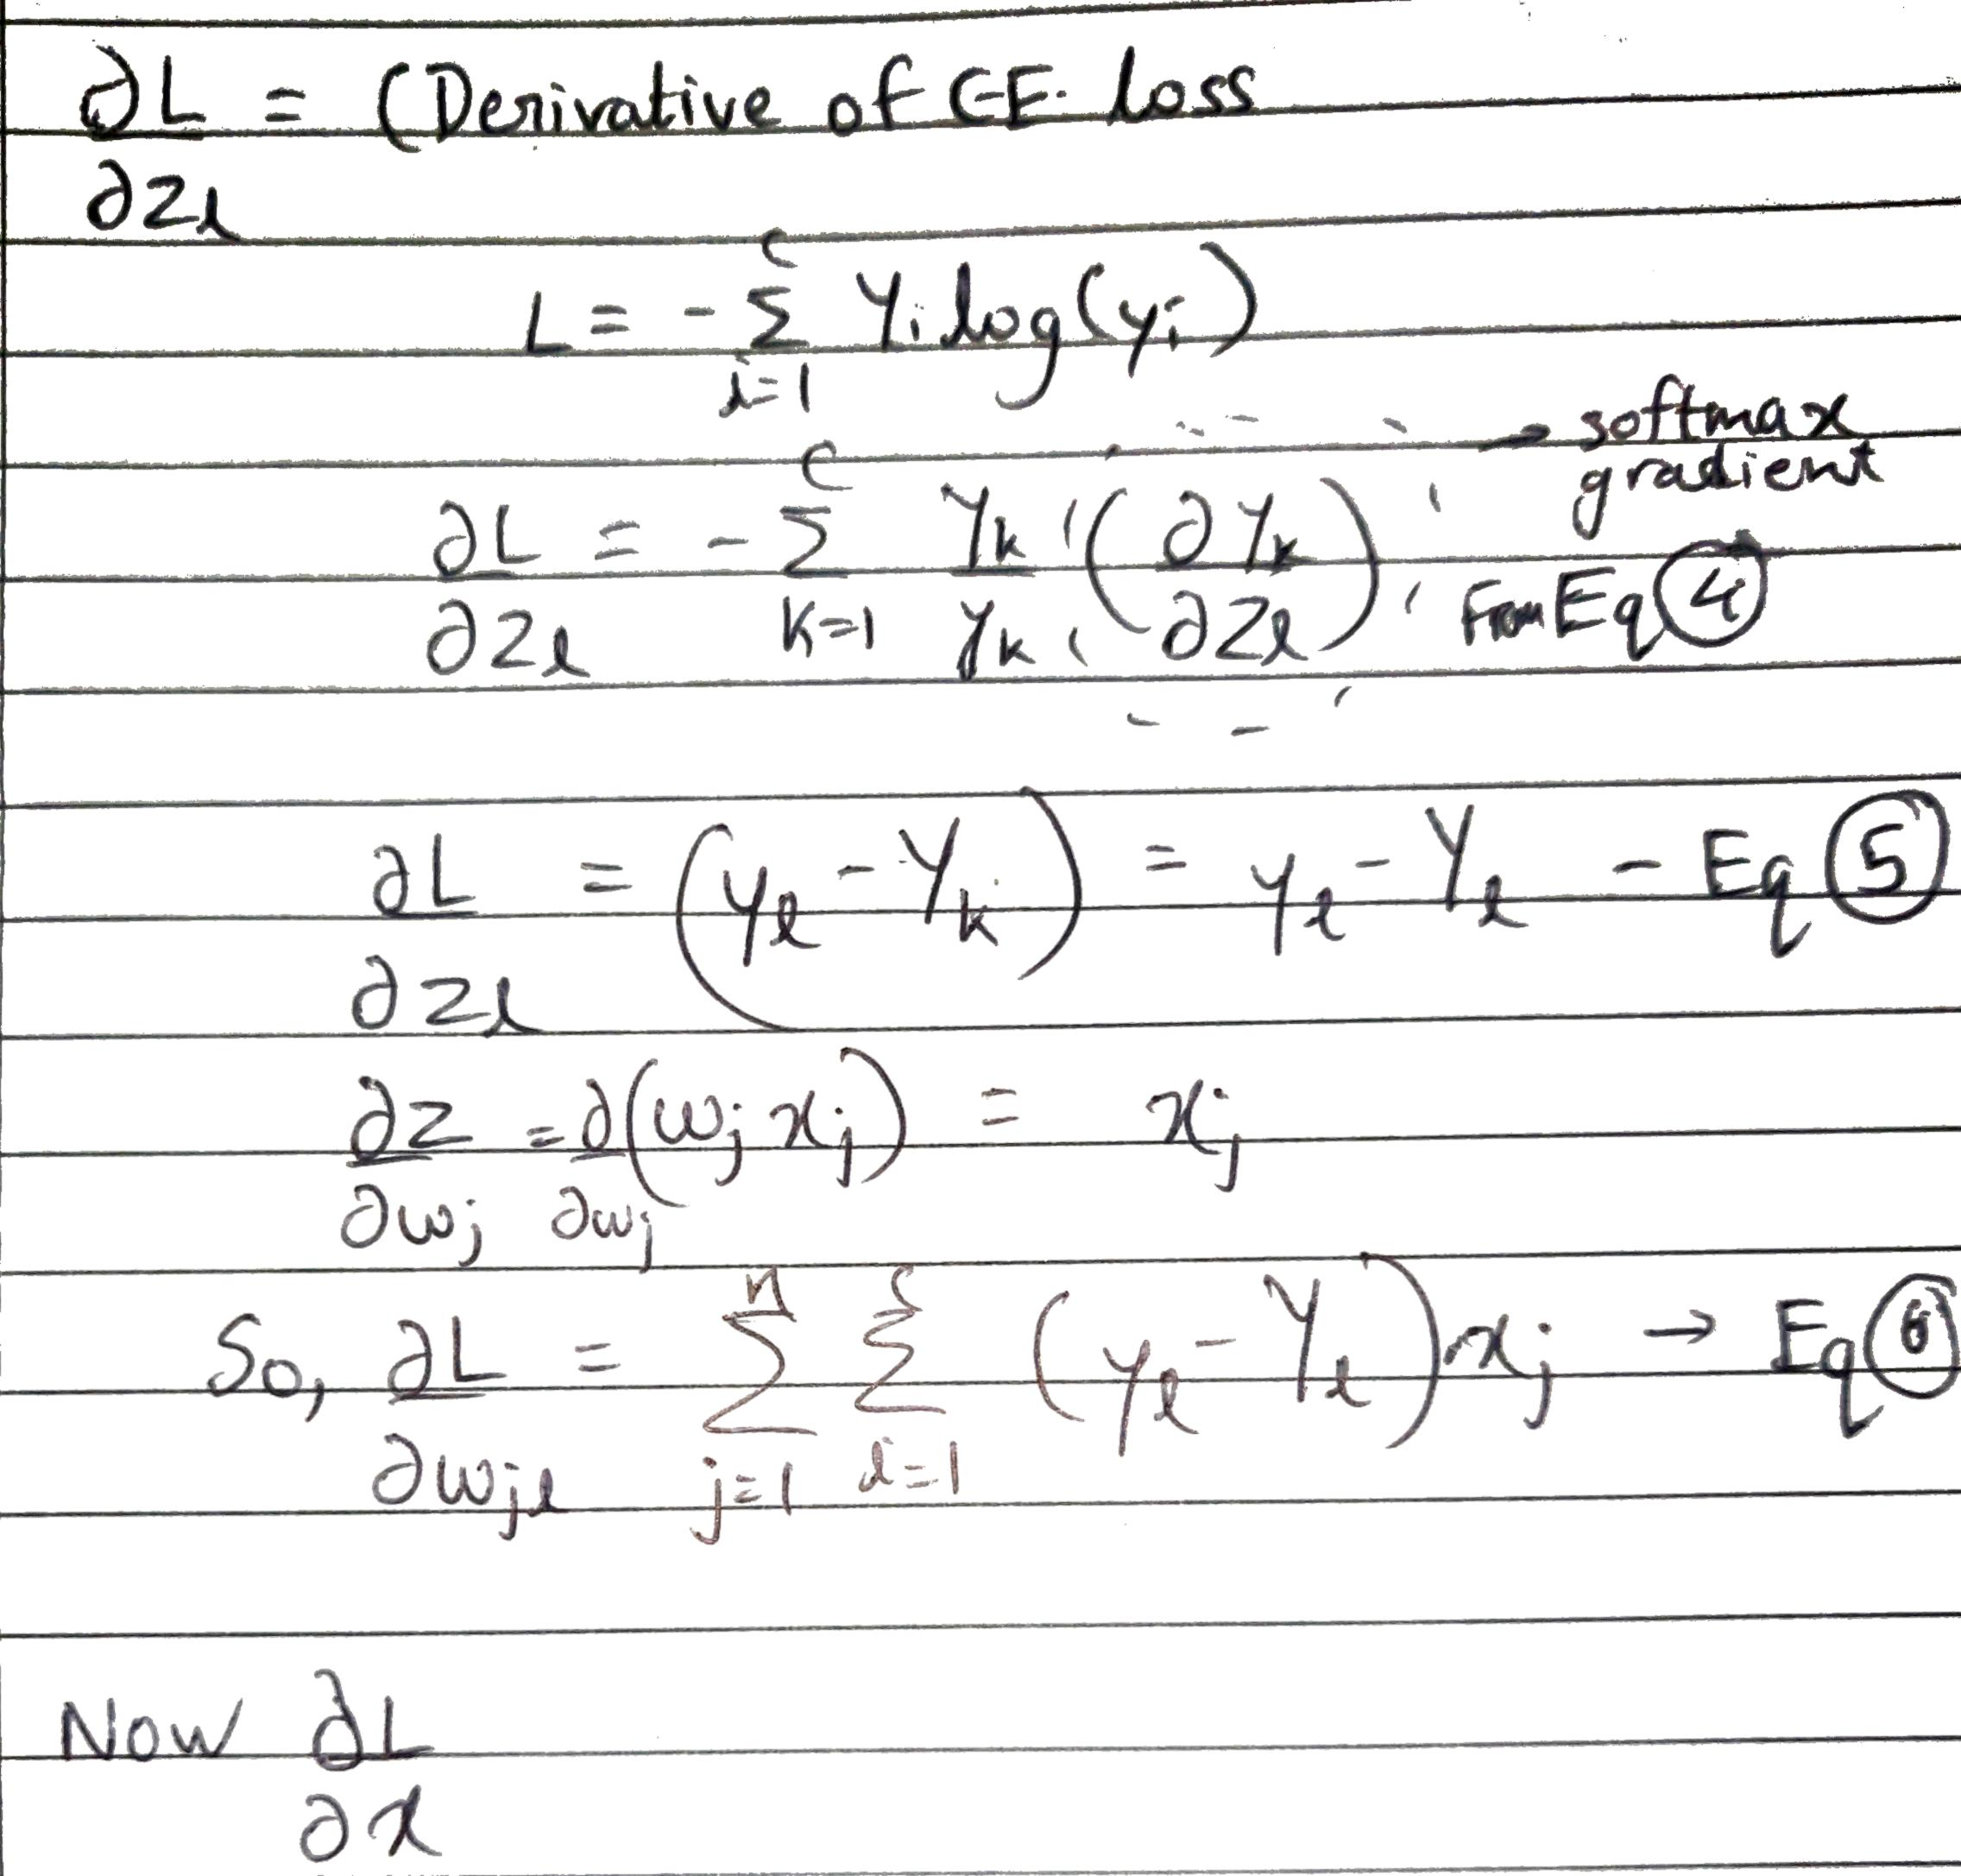

In [ ]:
class Softmax:
  def __init__(self, input_node, softmax_node):
    self.weight=np.random.randn(input_node,softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):

    self.orig_im_shape = image.shape
    image_modified = image.flatten()
    self.modified_input = image_modified
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out=output_val
    exp_out= np.exp(output_val)
    return exp_out/np.sum(exp_out,axis=0)

  def back_prop(self,dL_dout,learning_rate):
    for i ,grad in enumerate(dL_dout):
      if grad==0:
        continue
      
      transformation_eq=np.exp(self.out)
      S_total = np.sum(transformation_eq)
      #gradients wrt out(z)
      dy_dz=-transformation_eq[i]*transformation_eq / (S_total **2)
      dy_dz[i]=transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total **2)#refer softmax derivative section above for the derivations
      #grads wrt w,b and input
      dz_dw=self.modified_input #refer eqn below eqn 5
      dz_db=1 #always 1 as derivative of b wrt b is always 1.
      dz_d_inp=self.weight
      #grads of loss wrt totals
      dL_dz=grad * dy_dz  #refer eqn 4
      #grads of Loss wrt w,biases,input
      dL_dw= dz_dw[np.newaxis].T @ dL_dz[np.newaxis] #from Eqn 5 to 6
      dL_db= dL_dz * dz_db
      dL_d_inp= dz_d_inp @ dL_dz
      #updating w and bs
      self.weight-=learning_rate * dL_dw
      self.bias-=learning_rate * dL_db

      return dL_d_inp.reshape(self.orig_im_shape)

In [ ]:
#these dimensions coincide with the dimensions mentioned after every layer forward propagation in the part c.
conv = Conv_op(8,3) #28x28x1->26x26x8
pool = Max_Pool(2)  #26x26x8->13x13x8
softmax = Softmax(13*13*8,10) #13x13x8 --> 10

def cnn_forward_prop(image,label):
  out_p=conv.forward_prop((image/255)-0.5)
  out_p=pool.forward_prop(out_p)
  out_p=softmax.forward_prop(out_p)
  #calc cross entropy loss and accuracy
  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval



In [ ]:
def training_cnn(image, label, learn_rate=0.005):

  out, loss, acc= cnn_forward_prop(image, label)

  gradient = np.zeros(10)
  gradient[label]=-1/out[label]
  #the gradients obtained first will be passed to softmax layer for backprop
  #this backprop output will be fed to the maxpool and the backprop output from maxpool will be fed to convolution backprop function
  grad_back = softmax.back_prop(gradient,learn_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back= conv.back_prop(grad_back, learn_rate)

  return loss, acc

In [ ]:
train_images= X_train[:15000]
train_labels= y_train[:15000]
test_images= X_test[:1500]
test_labels = y_test[:1500]
for epoch1 in range(4):
  print('epoch %d-->' % (epoch1 + 1))

  shuffle_data = np.random.permutation(len(train_images))
  train_images= train_images[shuffle_data]
  train_labels= train_labels[shuffle_data]

  loss=0
  num_correct=0

  for i, (im, label) in enumerate(zip(train_images,train_labels)):
    if i % 100 ==0:
      print('Avg loss %.3f and Accuracy: %d%%' %(loss/100, num_correct))
      loss=0
      num_correct = 0

    l1, accu= training_cnn(im,label)
    loss += l1
    num_correct+=accu



epoch 1-->
Avg loss 0.000 and Accuracy: 0%
Avg loss 2.157 and Accuracy: 34%
Avg loss 2.002 and Accuracy: 42%
Avg loss 1.826 and Accuracy: 51%


In [ ]:
print('testing')

loss = 0
num_correct=0
for im, label in zip(test_images, test_labels):
  _, l1, accu = cnn_forward_prop(im, label)
  loss +=l1
  num_correct += accu

num_tests = len(test_images)
print('Test Loss',loss/num_tests)
print('Test Accuracy:', num_correct / num_tests)

testing
Test Loss 0.6073039905331998
Test Accuracy: 0.808
